# MNE Exploration
Angelo Pennati | June 12th, 2022

## Import Necessary Packages
Here we import the necessary packages to perform our exploratory analysis of the schizophrenia EEG task.

In [13]:
import mne
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from mne.channels import read_custom_montage
from sklearn.svm import SVC  # noqa
from sklearn.pipeline import Pipeline  # noqa
from sklearn.model_selection import cross_val_score, ShuffleSplit  # noqa
from mne.decoding import CSP  # noqa

## Retrieve sensor List
Here we read in the data that allows us to retrieve the names of all the sensors being used.

In [4]:
electrodes_list = list(pd.read_csv(r"C:\Users\penna\Documents\Porta\Education\Coding\EEG\data\columnLabels.csv").columns[4:])
print("Electrodes List \n",electrodes_list)

Electrodes List 
 ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'VEOa', 'VEOb', 'HEOL', 'HEOR', 'Nose', 'TP10']


## Load in some sample data
Here we load in some sample data using numpy's loadtxt() function.

In [5]:
sample_data = np.loadtxt(r"C:\Users\penna\Documents\Porta\Education\Coding\EEG\data\1.csv", delimiter = ',')

## Set up MNE Montage & Info
Here we use the metadata to determine the parameters for our subsequent MNE class. We set up: 

- Frequency
- Channel Types (as reported)

And we proceed to create a standard montage, as well as an info class. 

In [6]:
# Set the channel types and define the sampling frequency
ch_type = ['eeg']*64 + ['eog']*4 + ['misc'] + ['eeg']   
sfreq = 1024  # in Hertz (samples per second)

# read EEG standard montage from mne
montage = mne.channels.make_standard_montage(kind = 'standard_1005')
    
# Initialize required fields
info = mne.create_info(electrodes_list, sfreq, ch_type)

## Data Preparation & IO
Prepare data by removing unnecesssary rows and transposing. 

In [7]:
# Reshape data and transpose
sub3 = sample_data[:,4:].transpose()

# Treat the prepped data as input for MNE & set Montage
raw = mne.io.RawArray(sub3,info)
raw.set_montage(montage)

Creating RawArray with float64 data, n_channels=70, n_times=887808
    Range : 0 ... 887807 =      0.000 ...   866.999 secs
Ready.


<RawArray | 70 x 887808 (867.0 s), ~474.2 MB, data loaded>

## Initial raw data exploration
From the data we have already imported we can generate some important visualizations, such as:

- Power Spectrum
- Indivdiual Sensor Reads

The charts below are interactive and %matplotlib qt can be passed to pop them into their own window.

Effective window size : 2.000 (s)


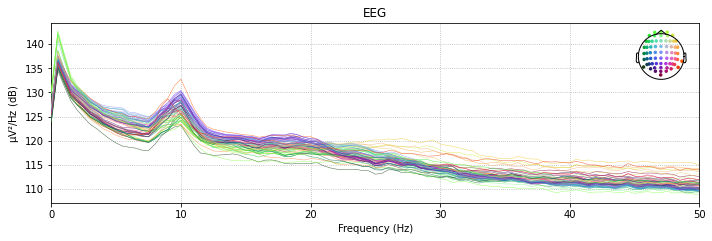

C:\Users\penna\AppData\Local\Temp\ipykernel_11384\3639667731.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


In [8]:
# Plot the Power Spectrum for the given trial participant
# pass qt to pop into own window

%matplotlib inline

fig = raw.plot_psd(fmax=50)
fig.show()

Using matplotlib as 2D backend.
Opening raw-browser...


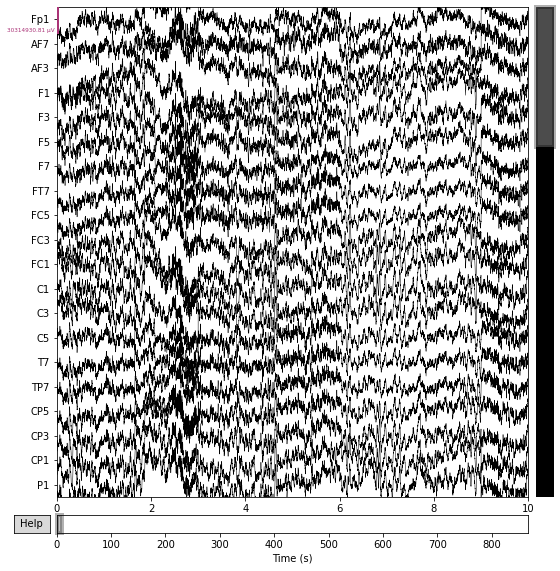

C:\Users\penna\AppData\Local\Temp\ipykernel_11384\1593407997.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  to.show()


In [9]:
# Plot the Individual sensor readings for the given trial participant
# pass qt to pop into own window
%matplotlib inline

to = raw.plot(scalings ='auto', clipping = 2 )
to.show()

## Define a function to read in epochs from a csv, rather than from the built-in MNE methods

Here, we define a function to work outside the bounds of the MNE sample data, and read-in a csv. This will allow us to:
- Read in data from an external source
- Reshape the data for ingestion by MNE function EpochsArray()
- Return the new MNE-compatible EpochsArray

In [27]:
def epochs_from_csvs(fname, info):
    """Create a mne epoch instance from csv file"""
    # Add some more information
    info['description'] = 'dataset from ' + fname
    
    # Trials were cut from -1.5 to 1.5 seconds
    tmin = -1.5

    # Read EEG file
    data = pd.read_csv(fname, header=None)
    
    #and convert it to numpy array:
    npdata = np.array(data)
    
    #sample 1537 is time 0, use that for the event 
    onsets = np.array(np.where(npdata[:,3]==1537))
    conditions = npdata[npdata[:,3]==1537,2]
    #use these to make an events array for mne (middle column are zeros):
    events = np.squeeze(np.dstack((onsets.flatten(), np.zeros(conditions.shape),conditions)))
   
    #now we just need EEGdata in a 3D shape (n_epochs, n_channels, n_samples)
    EEGdata = npdata.reshape(len(conditions),3072,74)

    #remove the first 4 columns (non-eeg, described above):
    EEGdata = EEGdata[:,:,4:]
    EEGdata = np.swapaxes(EEGdata,1,2)
    #create labels for the conditions, 1, 2, and 3:
    event_id = dict(button_tone=1, playback_tone=2, button_alone=3)
    
    # create raw object 
    custom_epochs = mne.EpochsArray(EEGdata, info=info, events=events.astype('int'), tmin=tmin, event_id=event_id)
    return custom_epochs

## Test our Function   
We test our function below:

In [110]:
trial_1 = epochs_from_csvs(r'../data/1.csv',info)
trial_1.set_montage(montage)

Not setting metadata
289 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


Number of events,289
Events,button_alone: 95button_tone: 100playback_tone: 94
Time range,-1.500 – 1.499 sec
Baseline,off


## Attempt to analyze components using Common Spatial Patterns
Here, we attempt to analyze our epoch data for this participant in order to understand whether we can predict the epoch based on a reduced feature space.

In [101]:
labels = trial_1.events[:, -1]
evoked = trial_1.average()
epoch_data = trial_1.get_data()
n_components = 10

svc = SVC(C=1, kernel='linear', verbose = False)
csp = CSP(n_components=n_components)

cv = ShuffleSplit(4, test_size=0.2, random_state=42)
clf = Pipeline([('CSP', csp),('SVC', svc)])
t_1_scores = cross_val_score(clf, epoch_data, labels, cv=cv, n_jobs=1)
print(t_1_scores.mean())  

Computing rank from data with rank=None
    Using tolerance 6.4e+02 (2.2e-16 eps * 70 dim * 4.1e+16  max singular value)
    Estimated rank (mag): 70
    MAG: rank 70 computed from 70 data channels with 0 projectors
Reducing data rank from 70 -> 70
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.2e+02 (2.2e-16 eps * 70 dim * 4e+16  max singular value)
    Estimated rank (mag): 70
    MAG: rank 70 computed from 70 data channels with 0 projectors
Reducing data rank from 70 -> 70
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.6e+02 (2.2e-16 eps * 70 dim * 4.3e+16  max singular value)
    Estimated rank (mag): 70
    MAG: rank 70 computed from 70 data channels with 0 projectors
Reducing data rank from 70 -> 70
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.5e+02 (2.2e-16 eps * 70 dim * 4.2e+16  max singular value)
  

### Attempt to predict using regularized CSP with Ledoit-Wolf Estimator
Here, we attempt to do the same task using a different estimator

In [ ]:
# And using reuglarized csp with Ledoit-Wolf estimator
csp = CSP(n_components=n_components, reg='ledoit_wolf')
clf = Pipeline([('CSP', csp), ('SVC', svc)])
t_2_scores = cross_val_score(clf, epoch_data, labels, cv=cv, n_jobs=1)
print(t_2_scores.mean())  

## Plot the CSP Patterns

Here, we attempt to visualize the results of our CSP analysis and plot the CSP Patterns for our 10 components. 

Computing rank from data with rank=None
    Using tolerance 7.1e+02 (2.2e-16 eps * 70 dim * 4.6e+16  max singular value)
    Estimated rank (mag): 70
    MAG: rank 70 computed from 70 data channels with 0 projectors
Reducing data rank from 70 -> 70
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 7.1e+02 (2.2e-16 eps * 70 dim * 4.6e+16  max singular value)
    Estimated rank (mag): 70
    MAG: rank 70 computed from 70 data channels with 0 projectors
Reducing data rank from 70 -> 70
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 7.5e+02 (2.2e-16 eps * 70 dim * 4.8e+16  max singular value)
    Estimated rank (mag): 70
    MAG: rank 70 computed from 70 data channels with 0 projectors
Reducing data rank from 70 -> 70
Estimating covariance using LEDOIT_WOLF
Done.


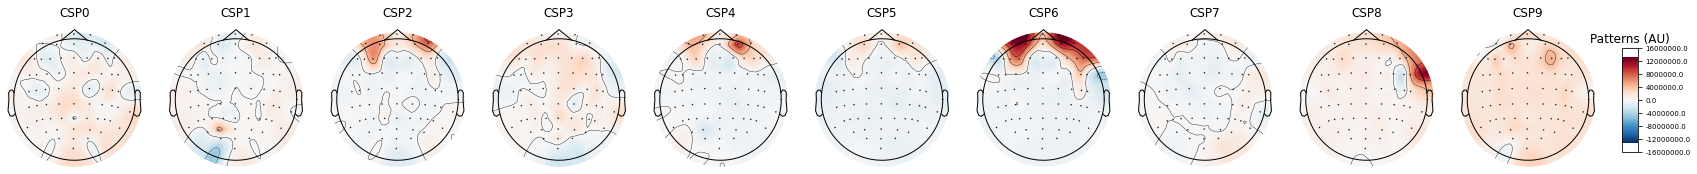

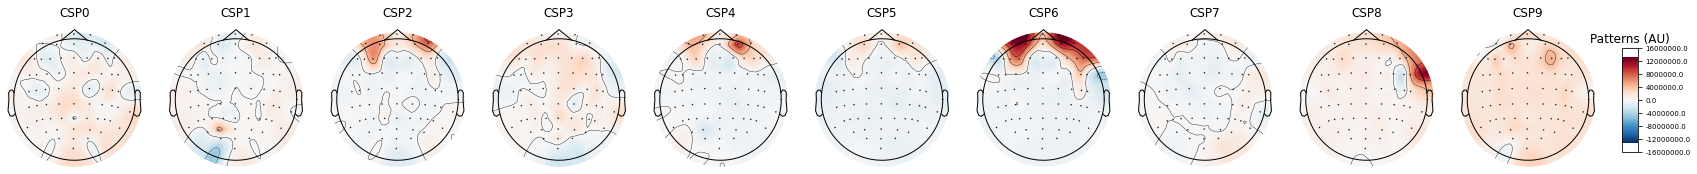

In [112]:
# plot CSP patterns estimated on full data for visualization
csp.fit_transform(epoch_data, labels)
csp.plot_patterns(trial_1.info, ch_type='eeg', size=1.5)